# NER: review aspects and sentiment

In [ ]:
!pip install -q evaluate seqeval
!pip install -q transformers[torch]

In [ ]:
!git clone https://github.com/named-entity/hse-nlp/

In [3]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [5]:
# read data into df
train_aspects = pd.read_csv('/content/hse-nlp/4th_year/Project/train_split_aspects.txt', sep='\t', header=None,
            names=['review_id', 'category', 'span', 'span_start', 'span_end', 'sentiment'])
dev_aspects = pd.read_csv('/content/hse-nlp/4th_year/Project/dev_aspects.txt', sep='\t', header=None,
            names=['review_id', 'category', 'span', 'span_start', 'span_end', 'sentiment'])

train_reviews = pd.read_csv('/content/hse-nlp/4th_year/Project/train_split_reviews.txt', sep='\t', header=None,
            names=['review_id', 'text', 'sentiment'])
dev_reviews = pd.read_csv('/content/hse-nlp/4th_year/Project/dev_reviews.txt', sep='\t', header=None,
            names=['review_id', 'text', 'sentiment'])

In [6]:
train_reviews.shape
train_aspects.shape

(3573, 6)

In [7]:
# concatenate sentiment and aspects labels
train_aspects['text_label'] = train_aspects.category + '_' + train_aspects.sentiment
dev_aspects['text_label'] = dev_aspects.category + '_' + dev_aspects.sentiment

In [8]:
# tokenize
from transformers import AutoTokenizer

model_checkpoint = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
tokenizer(train_reviews.text.sample().tolist())

{'input_ids': [[2, 29792, 43800, 314, 31144, 53735, 18, 57241, 2251, 1480, 56220, 16, 343, 6796, 6499, 20412, 16, 1046, 50505, 1563, 2749, 31122, 8054, 18, 5634, 4674, 13305, 41729, 18, 18, 18, 3086, 2079, 1046, 35301, 991, 11781, 29729, 751, 29762, 16, 343, 39633, 8281, 45406, 14860, 31350, 18397, 23729, 16, 2225, 2762, 73025, 57738, 872, 29841, 53999, 320, 61967, 1142, 21523, 14860, 619, 18, 288, 1046, 8281, 4983, 74534, 613, 320, 769, 37635, 16, 1619, 1046, 314, 33959, 314, 3368, 73025, 603, 1563, 41574, 33436, 8781, 26223, 23555, 13381, 16, 312, 44384, 40902, 626, 3846, 8781, 17252, 19491, 2215, 13240, 343, 1908, 320, 769, 34051, 5, 5849, 1046, 7081, 11352, 29595, 24730, 2993, 5219, 32670, 17824, 1109, 705, 30135, 75940, 1090, 16, 1619, 29719, 11345, 16, 1046, 29762, 26629, 30111, 31661, 30464, 27811, 5, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
train_reviews['input_ids'] = train_reviews.text.apply(lambda x: tokenizer([x]).input_ids)
dev_reviews['input_ids'] = dev_reviews.text.apply(lambda x: tokenizer([x]).input_ids)

train_reviews['tokens'] = train_reviews.text.apply(lambda x: tokenizer([x]).tokens())
dev_reviews['tokens'] = dev_reviews.text.apply(lambda x: tokenizer([x]).tokens())

In [11]:
train_aspects.columns

Index(['review_id', 'category', 'span', 'span_start', 'span_end', 'sentiment',
       'text_label'],
      dtype='object')

In [12]:
for col in ['span', 'span_start', 'span_end', 'text_label']:
    train_reviews = train_reviews.merge(train_aspects.groupby('review_id')[col].apply(lambda x: list(x)),
                                        left_on='review_id',
                                        right_index=True)

for col in ['span', 'span_start', 'span_end', 'text_label']:
    dev_reviews = dev_reviews.merge(dev_aspects.groupby('review_id')[col].apply(lambda x: list(x)),
                                        left_on='review_id',
                                        right_index=True)

In [13]:
dev_reviews.head()

,review_id,text,sentiment,input_ids,tokens,span,span_start,span_end,text_label
0,13823,"Зашли в""аппетит"" случайно.Не смотря на то,что ...",NaN,"[[2, 1647, 8075, 314, 6, 52341, 6, 31945, 18, ...","[[CLS], За, ##шли, в, "", аппетит, "", случайно,...","[аппетит, встретил, менеджер, девушка, проводи...","[7, 138, 147, 179, 188, 208, 242, 254, 337, 43...","[16, 146, 155, 186, 205, 217, 252, 267, 345, 4...","[Whole_neutral, Service_neutral, Service_neutr..."
1,1427,Здравствуйте!Посетили ваше заведение вчера пер...,NaN,"[[2, 54471, 5, 44000, 4307, 34084, 40640, 3206...","[[CLS], Здравствуйте, !, Посет, ##или, ваше, з...","[заведение, ужинали, обслуживанием, посещение,...","[27, 113, 169, 205, 222, 333, 350, 394, 407, 4...","[36, 120, 182, 214, 231, 337, 357, 402, 422, 4...","[Whole_positive, Food_neutral, Service_negativ..."
2,16714,"Были в пятницу (19.03.10), заказывали столик д...",NaN,"[[2, 32846, 314, 31641, 12, 682, 18, 1125, 18,...","[[CLS], Были, в, пятницу, (, 19, ., 03, ., 10,...","[заказывали столик, кухню, шашлык по азейрбадж...","[27, 118, 136, 176, 199, 214, 230, 282, 315, 3...","[44, 123, 174, 197, 211, 228, 238, 286, 320, 3...","[Service_neutral, Food_neutral, Food_neutral, ..."
3,797,"Были в ресторане 2 раза. Один раз днем, все по...",NaN,"[[2, 32846, 314, 43751, 22, 16495, 18, 12146, ...","[[CLS], Были, в, ресторане, 2, раза, ., Один, ...","[ресторане, выпить, чаю, вина, официантка, рес...","[7, 89, 96, 102, 143, 287, 313, 550, 645]","[16, 95, 99, 106, 153, 296, 323, 560, 651]","[Whole_neutral, Food_neutral, Food_neutral, Fo..."
4,34710,Удивляюсь отзывам про хорошее обслуживание. Бы...,NaN,"[[2, 42733, 887, 68579, 75161, 2225, 34420, 34...","[[CLS], Уди, ##в, ##ляюсь, отзывам, про, хорош...","[обслуживание, обслужили, несли, напитки, сала...","[30, 86, 129, 135, 162, 174, 234, 285, 362, 38...","[42, 95, 134, 142, 167, 178, 254, 295, 366, 39...","[Service_positive, Service_positive, Service_n..."


In [14]:
tokenizer(dev_reviews.loc[0, 'text'])

{'input_ids': [2, 1647, 8075, 314, 6, 52341, 6, 31945, 18, 6226, 36019, 548, 1619, 16, 1046, 991, 59415, 775, 4045, 12, 32123, 662, 3448, 13, 320, 14604, 4064, 10145, 16, 2749, 1712, 30446, 32776, 18, 10227, 39170, 31514, 17, 42608, 29499, 12984, 776, 31897, 1545, 30354, 16, 47356, 322, 52978, 320, 20408, 33959, 18, 18, 18, 32880, 25, 14860, 32127, 57738, 872, 16, 27278, 29762, 320, 69807, 5750, 18, 18, 18, 36492, 29454, 15213, 11521, 66592, 1046, 31661, 30590, 27811, 17, 35301, 991, 55509, 16, 4580, 11521, 72985, 5725, 16, 57370, 1563, 68481, 72509, 17, 29472, 30324, 15324, 2641, 871, 31519, 32347, 16, 650, 63214, 70927, 1373, 11521, 769, 35366, 1150, 29786, 1614, 18, 18, 18, 37923, 8394, 679, 1669, 16, 548, 45608, 16, 19285, 6003, 32946, 1635, 320, 50287, 1635, 17, 29472, 28896, 4182, 32275, 18, 282, 30579, 6003, 34420, 2554, 16, 30679, 2182, 50505, 626, 33959, 16, 39581, 3215, 30189, 320, 38683, 30524, 33619, 5, 18252, 6003, 2749, 37635, 18, 33020, 13064, 31390, 38298, 5, 30440, 328

In [15]:
# convert tokens to iob

def span_to_iob(tokenized, starts, ends, text_labels):
    tokens = tokenized.tokens()
    aligned_labels = ['O'] * len(tokens)
    # Make a list to store our labels the same length as our tokens
    for start, end, label in zip(starts, ends, text_labels):
        annotation_token_ix_set = (
            set()
        ) # A set that stores the token indices of the annotation
        for char_ix in range(start, end):
            token_ix = tokenized.char_to_token(char_ix)
            if token_ix is not None:
                annotation_token_ix_set.add(token_ix)
        sorted_annotation_token_ix_set = sorted(annotation_token_ix_set)
        for num, token_ix in enumerate(sorted_annotation_token_ix_set):
            if num == 0: # or tokenized.token_to_word(token_ix) == tokenized.token_to_word(sorted_annotation_token_ix_set[0]):
                prefix = 'B'
            else:
                prefix = 'I' # We're inside of a multi token annotation
            aligned_labels[token_ix] = f"{prefix}-{label}"
    return aligned_labels

span_to_iob(
    tokenizer(dev_reviews.loc[0, 'text']),
    dev_reviews.loc[0, 'span_start'],
    dev_reviews.loc[0, 'span_end'],
    dev_reviews.loc[0, 'text_label'],
             )

['O',
 'O',
 'O',
 'O',
 'B-Whole_neutral',
 'I-Whole_neutral',
 'I-Whole_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'B-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'I-Service_neutral',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Whole_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Food_positive',
 'I-Food_positive',
 'I-Fo

In [16]:
train_labels = [span_to_iob(tokenizer([row[1][0]]), *row[1][1:])
                for row in train_reviews[['text', 'span_start', 'span_end', 'text_label']].iterrows()]
dev_labels = [span_to_iob(tokenizer([row[1][0]]), *row[1][1:])
                for row in dev_reviews[['text', 'span_start', 'span_end', 'text_label']].iterrows()]

In [17]:
train_reviews['labels'] = train_labels
dev_reviews['labels'] = dev_labels

In [18]:
train_reviews.head()

,review_id,text,sentiment,input_ids,tokens,span,span_start,span_end,text_label,labels
0,25709,"Были 1 февраля. Я второй раз, подруга - первый...",NaN,"[[2, 32846, 21, 3840, 18, 311, 5509, 4495, 16,...","[[CLS], Были, 1, февраля, ., Я, второй, раз, ,...","[девушки, заведения, диваны, подушек, музыка, ...","[168, 302, 347, 365, 402, 418, 442, 458, 583, ...","[175, 311, 353, 372, 408, 426, 453, 467, 587, ...","[Service_positive, Whole_neutral, Interior_pos...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,10099,Были в Дитае на прошлой неделе с подругой. Заш...,NaN,"[[2, 32846, 314, 54312, 10633, 548, 34700, 314...","[[CLS], Были, в, Дит, ##ае, на, прошлой, недел...","[Дитае, официантки, судака, свинину по-пекинск...","[7, 176, 235, 249, 270, 356, 367, 476, 483, 549]","[12, 186, 241, 268, 273, 365, 372, 482, 492, 559]","[Whole_neutral, Service_positive, Food_neutral...","[O, O, O, B-Whole_neutral, I-Whole_neutral, O,..."
2,1105,Один из моих любимых ресторанов. С самого откр...,NaN,"[[2, 12146, 778, 34086, 40103, 38405, 18, 297,...","[[CLS], Один, из, моих, любимых, ресторанов, ....","[ресторанов, дисконтную карту, борщ с копченос...","[21, 113, 219, 240, 267, 372, 439, 461, 503, 5...","[31, 129, 238, 254, 278, 377, 451, 486, 509, 5...","[Whole_positive, Service_positive, Food_positi...","[O, O, O, O, O, B-Whole_positive, O, O, O, O, ..."
3,3647,Остались очень довольны. Хотим поблагодарить ш...,NaN,"[[2, 32150, 4388, 6003, 48309, 18, 43938, 656,...","[[CLS], Оста, ##лись, очень, довольны, ., Хоти...","[шеф повара, салаты, горячее, Порции, пиво, це...","[45, 68, 77, 86, 142, 198, 217, 243, 277, 366,...","[55, 74, 84, 92, 146, 202, 229, 253, 286, 374,...","[Food_positive, Food_positive, Food_positive, ...","[O, O, O, O, O, O, O, O, O, B-Food_positive, I..."
4,37070,приехали к друзьям в Питер из Москвы на Новый ...,NaN,"[[2, 36595, 322, 40821, 314, 21408, 778, 10510...","[[CLS], приехали, к, друзьям, в, Питер, из, Мо...","[заведение, кухня, интерьер, еда, чек, место, ...","[82, 116, 123, 132, 143, 205, 224]","[91, 121, 131, 135, 146, 210, 241]","[Whole_positive, Food_positive, Interior_posit...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [19]:
# build dataset

from transformers import DataCollatorForTokenClassification, DefaultDataCollator, DataCollatorWithPadding

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

class TokenDataset:
    def __init__(self,
                 df, label2id
            ):
        self.tokenized = tokenizer(df.text.tolist())
        self.labels = df.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = self.tokenized.input_ids[idx]
        attention_mask = self.tokenized.attention_mask[idx]
        token_type_ids = self.tokenized.token_type_ids[idx]
        labels = [label2id[ele] for ele in self.labels[idx]]

        return {
                'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask,
                'labels': labels
               }

In [20]:
label_names = list(set(sum(train_labels, [])))
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

train_set = TokenDataset(train_reviews, label2id)
dev_set = TokenDataset(dev_reviews, label2id)

In [21]:
train_sample = train_reviews.sample()

for i in range(0, 100, 10):
    print(*train_sample['tokens'].values[0][i:i+10], sep='\t\t\t')
    print(*train_sample['labels'].values[0][i:i+10], sep='\t\t\t')
    print()

[CLS]			Была			в			этом			ресторане			уже			четыре			раза			с			декабря
O			O			O			O			B-Whole_neutral			O			O			O			O			O

прошлого			года			.			Прекрасно			##е			вино			,			вкус			##ная			еда
O			O			O			O			O			B-Food_positive			O			O			O			B-Food_positive

с			красивой			подачей			,			спокойная			атмосфера			и			замечательно			##е			обслуживание
O			O			B-Food_positive			O			O			B-Interior_positive			O			O			O			B-Service_positive

.			Что			касается			оценок			(			от			1			-			10			)
O			O			O			O			O			O			O			O			O			O

:			-			7			ставлю			за			кухню			потому			,			что			хотелось
O			O			O			O			O			B-Food_both			O			O			O			O

бы			больше			разнообразия			в			меню			по			основным			блюда			##м			.
O			O			O			O			B-Food_positive			O			O			B-Food_positive			I-Food_positive			O

-			5			за			интерьер			-			не			очень			уютно			на			этих
O			O			O			B-Interior_both			O			O			O			O			O			O

стулья			##х			,			сум			##очку			никуда			не			поставить			,			оптимальные
B-Interior_neg

In [22]:
dev_sample = dev_reviews.sample()

for i in range(0, 100, 10):
    print(*dev_sample['tokens'].values[0][i:i+10], sep='\t\t\t')
    print(*dev_sample['labels'].values[0][i:i+10], sep='\t\t\t')
    print()

[CLS]			Отличный			интерьер			!			Прият			##ная			атмосфера			и			живая			музыка
O			O			B-Interior_positive			O			O			O			B-Interior_positive			O			B-Interior_positive			I-Interior_positive

(			акко			##рде			##он			)			.			Интересно			##е			оформление			блюд
O			O			O			O			O			O			O			O			B-Food_positive			I-Food_positive

!			-			Это			все			поднимает			настроение			!			Ожи			##дание			МЕ
O			O			O			O			O			O			O			O			O			O

##Н			##Ю			более			15			минут			(			ресторан			был			пустой			,
O			O			O			O			O			O			O			O			O			O

праздно			##вали			в			одной			комнате			,			а			3			столик			##а
O			O			O			O			O			O			O			O			O			O

в			главном			зале			ждали			пока			те			зака			##жут			,			чтоб
O			O			O			B-Service_negative			O			O			O			O			O			O

нам			передать			меню			!			)			.			Очень			медленно			##е			обслуживание
O			O			O			O			O			O			O			O			O			B-Service_negative

(			или			мало			повар			##ов			или			официант			##ов			)			.
O			O			O			B-Service_negative			I-Service

In [23]:
# evaluation metrics
# source https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/en/chapter7/section2_pt.ipynb#scrollTo=Uf6wsPeyfIHm

import evaluate

metric = evaluate.load('seqeval')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return {
        'precision': all_metrics['overall_precision'],
        'recall': all_metrics['overall_recall'],
        'f1': all_metrics['overall_f1'],
        'accuracy': all_metrics['overall_accuracy'],
    }

In [24]:
# the train pipeline
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

def train_model(lr, epochs, dropout=0.1, model=None, freeze_bert=False):
    if model == None:
        model = AutoModelForTokenClassification.from_pretrained(
            model_checkpoint,
            id2label=id2label,
            label2id=label2id,
        )

    if freeze_bert:
        for param in model.bert.parameters():
            param.requires_grad = False

    model.dropout.p = dropout

    args = TrainingArguments(
        'rubert-tiny2-absa',
        logging_strategy='epoch',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        metric_for_best_model='f1',
        save_total_limit=1,
        load_best_model_at_end=True,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=lr,
        num_train_epochs=epochs,
        weight_decay=0.01,
        push_to_hub=False,
    )

    data_collator = DataCollatorForTokenClassification(tokenizer)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_set,
        eval_dataset=dev_set,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    trainer.train()

    return model

### Эксперимент 1

Обучаем модель 70 эпох:

In [ ]:
model_1 = train_model(lr=2e-4, epochs=70)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.592300,0.926008,0.000000,0.000000,0.000000,0.833958
2,0.828200,0.712803,0.128767,0.039496,0.060450,0.841597
3,0.669700,0.622691,0.237179,0.124370,0.163175,0.853993
4,0.567400,0.544499,0.327916,0.288235,0.306798,0.871072
5,0.464100,0.495682,0.405299,0.347059,0.373925,0.880369
6,0.391500,0.469704,0.379483,0.382353,0.380913,0.882099
7,0.346200,0.457576,0.378317,0.419328,0.397768,0.880873
8,0.292700,0.456435,0.383447,0.424370,0.402872,0.881018
9,0.256200,0.468906,0.369580,0.451261,0.406356,0.879576
10,0.234000,0.459455,0.376018,0.426891,0.399843,0.881666


### Эксперимент 2

Заморозим все веса, кроме полносвязного слоя в конце.

In [25]:
model_2 = train_model(lr=2e-4, epochs=50, freeze_bert=True)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.489900,3.213063,0.004882,0.027731,0.008303,0.418781
2,3.041100,2.764445,0.004167,0.005882,0.004878,0.744379
3,2.616300,2.350586,0.000000,0.000000,0.000000,0.815581
4,2.227600,1.980580,0.000000,0.000000,0.000000,0.830643
5,1.892000,1.664174,0.000000,0.000000,0.000000,0.833526
6,1.600800,1.406902,0.000000,0.000000,0.000000,0.834102
7,1.378300,1.207904,0.000000,0.000000,0.000000,0.834102
8,1.188600,1.059161,0.000000,0.000000,0.000000,0.834174
9,1.057400,0.950926,0.000000,0.000000,0.000000,0.834174
10,0.955400,0.871844,0.000000,0.000000,0.000000,0.834174


Разморозим веса и обучим дальше:

In [26]:
for param in model_2.parameters():
    param.requires_grad = True

In [27]:
model_2 = train_model(lr=1e-4, epochs=70, model=model_2)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.520900,0.453719,0.376585,0.324370,0.348533,0.880441
2,0.437100,0.419557,0.390909,0.361345,0.375546,0.884261
3,0.390400,0.400555,0.396450,0.394118,0.395280,0.888585
4,0.356500,0.386572,0.406678,0.399160,0.402884,0.890963
5,0.317500,0.377633,0.415543,0.440336,0.427581,0.891828
6,0.291200,0.371801,0.409532,0.426050,0.417628,0.893773
7,0.274500,0.367417,0.408754,0.463025,0.434200,0.895215
8,0.243400,0.368031,0.412556,0.463866,0.436709,0.896440
9,0.221400,0.370787,0.414747,0.453782,0.433387,0.896728
10,0.203800,0.376518,0.428571,0.463866,0.445521,0.898818


### Эксперимент 3

Аналогичен эксперименту 2, но с бóльшим количеством эпох и dropout перед полносвязным слоем 0.5.

In [ ]:
model_3 = train_model(lr=2e-4, epochs=70, dropout=0.5, freeze_bert=True)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.696900,3.394459,0.005195,0.044538,0.009305,0.182978
2,3.237700,2.937524,0.005630,0.013445,0.007937,0.676131
3,2.803200,2.508358,0.004367,0.001681,0.002427,0.816085
4,2.402500,2.116057,0.010526,0.000840,0.001556,0.832228
5,2.048000,1.771927,0.000000,0.000000,0.000000,0.833886
6,1.733500,1.485573,0.000000,0.000000,0.000000,0.834030
7,1.492900,1.260875,0.000000,0.000000,0.000000,0.833886
8,1.288000,1.093185,0.000000,0.000000,0.000000,0.833958
9,1.141200,0.972762,0.000000,0.000000,0.000000,0.833958
10,1.031500,0.887537,0.000000,0.000000,0.000000,0.833958


In [ ]:
for param in model_3.parameters():
    param.requires_grad = True

In [ ]:
model_3 = train_model(lr=1e-4, epochs=80, model=model_3, dropout=0.5)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.556200,0.454487,0.381958,0.334454,0.356631,0.879865
2,0.474800,0.425810,0.405825,0.351261,0.376577,0.884405
3,0.427200,0.404097,0.397993,0.400000,0.398994,0.887720
4,0.389200,0.391626,0.416376,0.401681,0.408896,0.890386
5,0.351200,0.383870,0.413376,0.431092,0.422049,0.891395
6,0.326100,0.381540,0.428096,0.432773,0.430422,0.892764
7,0.309700,0.374897,0.419984,0.452101,0.435451,0.894350
8,0.274600,0.376016,0.414080,0.459664,0.435683,0.894494
9,0.252800,0.379279,0.424923,0.461345,0.442385,0.896007
10,0.237900,0.388476,0.423465,0.457983,0.440048,0.897088


Dropout не улучшил качество модели по сравнению с предыдущим экспериментом. Сохраняем модель 2:

In [ ]:
model_2.push_to_hub('rubert-tiny2-ner-absa-v1')

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bert-base/rubert-tiny2-ner-absa-v1/commit/24e056d1203795359a6360080735d8a84019867d', commit_message='Upload BertForTokenClassification', commit_description='', oid='24e056d1203795359a6360080735d8a84019867d', pr_url=None, pr_revision=None, pr_num=None)

### Предсказания на валидации

In [28]:
# pass output of tokenizer to device
def tokenized_to_cuda(text):
    tokenized = tokenizer([text], return_tensors='pt')
    for key in tokenized:
        tokenized[key] = tokenized[key].to('cuda')
    return tokenized

def predict_labels(texts, model):
    return [
        [id2label[ele.item()] for ele in model(**tokenized_to_cuda(text)).logits.argmax(dim=-1)[0]]
    for text in texts]

dev_preds = predict_labels(dev_reviews.text, model_2)
train_preds = predict_labels(train_reviews.text, model_2)

In [29]:
def iob_to_span(tokenized, iob_labels):
    tokens = tokenized.tokens()
    starts, ends, text_labels = [], [], []
    for i, (token, label) in enumerate(zip(tokens, iob_labels)):
        span = tokenized.token_to_chars(i)
        if span is not None:
            start, end = span
            if label.startswith('B') or label.startswith('I'):
                starts.append(start)
                ends.append(end)
                text_labels.append(label)

    merged_starts, merged_ends, merged_text_labels = starts[:1], [], text_labels[:1]
    for i, label in enumerate(text_labels):
        if label.startswith('B'):
            merged_ends.append(ends[i-1])
            merged_starts.append(starts[i])
            merged_text_labels.append(label[2:])
    merged_ends.append(ends[-1])

    return merged_starts[1:], merged_ends[1:], merged_text_labels[1:]

In [30]:
for start, end, ent in zip(*iob_to_span(tokenizer(train_reviews.text[0]), train_preds[0])):
    print(train_reviews.text[0][start:end], start, end, ent, sep='\t')

девушки	168	175	Service_positive
заведения	302	311	Whole_neutral
диваны	347	353	Interior_positive
подушек	365	372	Interior_positive
музыка	402	408	Interior_positive
полумрак	418	426	Interior_positive
обслуживало	442	453	Service_neutral
официанта	458	467	Service_neutral
вина	583	587	Food_neutral
коктейльным напитком	597	617	Food_neutral
Медальоны из говядины с запеченным картофелем	666	711	Food_positive
рыбы	763	767	Food_neutral
приготовленное	799	813	Food_positive
мясо	814	818	Food_positive
Заказ принесли	820	834	Service_positive
обслуживании	885	897	Service_positive
ресторане	964	973	Whole_positive
заведения	1102	1111	Whole_positive


In [31]:
for start, end, ent in zip(*iob_to_span(tokenizer(dev_reviews.text[0]), dev_preds[0])):
    print(dev_reviews.text[0][start:end], start, end, ent, sep='\t')

менеджер- темноволосая	147	169	Service_positive
девушка, проводила к столу и дала меню	179	217	Service_positive
официантка	242	252	Service_neutral
приняла заказ	254	267	Service_neutral
удалил	270	276	Service_negative
ждать	315	320	Service_positive
ресторан	337	345	Whole_positive
заведения	431	440	Whole_positive
Бизнес ланч	495	506	Food_positive
цене	582	586	Price_positive
место	610	615	Whole_positive
меню	639	643	Food_positive
цены	656	660	Price_positive
качество обслуживания	671	692	Service_positive
заведению	735	744	Whole_positive


### Сохраняем результаты NER

In [32]:
with open('dev_pred_aspects.txt', 'w') as f:
    for review_id, text, preds in zip(dev_reviews.review_id.tolist(),
                                      dev_reviews.text.tolist(),
                                      dev_preds):
        for start, end, ent in zip(*iob_to_span(tokenizer(text), preds)):
            token = text[start:end]
            aspect, sentiment = ent.split('_')
            print(review_id, aspect, token, start, end, sentiment, sep='\t', end='\n', file=f)

with open('train_pred_aspects.txt', 'w') as f:
    for review_id, text, preds in zip(train_reviews.review_id.tolist(),
                                      train_reviews.text.tolist(),
                                      train_preds):
        for start, end, ent in zip(*iob_to_span(tokenizer(text), preds)):
            aspect, sentiment = ent.split('_')
            token = text[start:end]
            print(review_id, aspect, token, start, end, sentiment, sep='\t', end='\n', file=f)

### Сохраняем результаты ABSA

Посчитаем упоминания аспектов с предсказанной тональностью, припишем

-   ```absence``` - если нет упоминаний данной категории
- ```both``` - если есть упоминания с разной тональностью
- ```positive/neutral/negative``` - если все упоминания одной тональности

In [33]:
CATEGORIES = ['Whole', 'Interior', 'Service', 'Food', 'Price']

In [34]:
def get_full_sentiment(text, max_len=5):
    asp_counter = defaultdict(Counter)
    for start, end, ent in zip(*iob_to_span(tokenizer(text), preds)):
        aspect, sentiment = ent.split('_')
        asp_counter[aspect][sentiment] += 1
    for c in CATEGORIES:
        if not asp_counter[c]:
            s = 'absence'
        elif len(asp_counter[c]) == 1:
            s = asp_counter[c].most_common(1)[0][0]
        else:
            s = 'both'
        yield c, s

In [35]:
with open('dev_pred_cats.txt', 'w') as f:
    for review_id, text, preds in zip(dev_reviews.review_id.tolist(),
                                  dev_reviews.text.tolist(),
                                  dev_preds):
        for aspect, sentiment in get_full_sentiment(text):
            print(review_id, aspect, sentiment, sep='\t', end='\n', file=f)

with open('train_pred_cats.txt', 'w') as f:
    for review_id, text, preds in zip(train_reviews.review_id.tolist(),
                                  train_reviews.text.tolist(),
                                  train_preds):
        for aspect, sentiment in get_full_sentiment(text):
            print(review_id, aspect, sentiment, sep='\t', end='\n', file=f)

## Оценка 1: accuracy по выделению упоминаний с категориями

In [36]:
gold_aspects_test_path = '/content/hse-nlp/4th_year/Project/dev_aspects.txt'
baseline_aspects_test_path = '/content/hse-nlp/4th_year/Project/dev_pred_aspects.txt'
pred_aspects_test_path = '/content/dev_pred_aspects.txt'

gold_cats_test_path = '/content/hse-nlp/4th_year/Project/dev_cats.txt'
baseline_cats_test_path = '/content/hse-nlp/4th_year/Project/dev_pred_cats.txt'
pred_cats_test_path = '/content/dev_pred_cats.txt'

In [37]:
def evaluate_ner(gold_test_path, pred_test_path):
    gold_aspect_cats = {}
    with open(gold_test_path) as fg:
        for line in fg:
            line = line.rstrip('\r\n').split('\t')
            if line[0] not in gold_aspect_cats:
                gold_aspect_cats[line[0]] = {'starts':[], 'ends':[], 'cats':[], 'sents':[]}
            gold_aspect_cats[line[0]]['starts'].append(int(line[3]))
            gold_aspect_cats[line[0]]['ends'].append(int(line[4]))
            gold_aspect_cats[line[0]]['cats'].append(line[1])
            gold_aspect_cats[line[0]]['sents'].append(line[5])

    full_match, partial_match, full_cat_match, partial_cat_match = 0, 0, 0, 0
    total = 0
    fully_matched_pairs = []
    partially_matched_pairs = []
    with open(pred_test_path) as fp:
        for line in fp:
            total += 1
            line = line.rstrip('\r\n').split('\t')
            start, end = int(line[3]), int(line[4])
            category = line[1]
            doc_gold_aspect_cats = gold_aspect_cats[line[0]]
            if start in doc_gold_aspect_cats['starts']:
                i = doc_gold_aspect_cats['starts'].index(start)
                if doc_gold_aspect_cats['ends'][i] == end:
                    full_match += 1
                    if doc_gold_aspect_cats['cats'][i] == category:
                        full_cat_match += 1
                    else:
                        partial_cat_match += 1
                    fully_matched_pairs.append(
                        (
                            [
                                doc_gold_aspect_cats['starts'][i],
                                doc_gold_aspect_cats['ends'][i],
                                doc_gold_aspect_cats['cats'][i],
                                doc_gold_aspect_cats['sents'][i]
                            ],
                            line
                        )
                    )
                    continue
            for s_pos in doc_gold_aspect_cats['starts']:
                if start <= s_pos:
                    i = doc_gold_aspect_cats['starts'].index(s_pos)
                    if doc_gold_aspect_cats['ends'][i] == end:
                        partial_match += 1
                        partially_matched_pairs.append(
                            (
                                [
                                    doc_gold_aspect_cats['starts'][i],
                                    doc_gold_aspect_cats['ends'][i],
                                    doc_gold_aspect_cats['cats'][i],
                                    doc_gold_aspect_cats['sents'][i]
                                ],
                                line
                            )
                        )
                        if doc_gold_aspect_cats['cats'][i] == category:
                            partial_cat_match += 1
                        continue
                    matched = False
                    for e_pos in doc_gold_aspect_cats['ends'][i:]:
                        if s_pos <= end <= e_pos:
                            partial_match += 1
                            partially_matched_pairs.append(
                                (
                                    [
                                        doc_gold_aspect_cats['starts'][i],
                                        doc_gold_aspect_cats['ends'][i],
                                        doc_gold_aspect_cats['cats'][i],
                                        doc_gold_aspect_cats['sents'][i]
                                    ],
                                    line
                                )
                            )
                            if doc_gold_aspect_cats['cats'][i] == category:
                                partial_cat_match += 1
                            matched = True
                            break
                    if matched:
                        break
                if start > s_pos:
                    i = doc_gold_aspect_cats['starts'].index(s_pos)
                    if start < doc_gold_aspect_cats['ends'][i] <= end:
                        partial_match += 1
                        partially_matched_pairs.append(
                            (
                                [
                                    doc_gold_aspect_cats['starts'][i],
                                    doc_gold_aspect_cats['ends'][i],
                                    doc_gold_aspect_cats['cats'][i],
                                    doc_gold_aspect_cats['sents'][i]
                                ],
                                line
                            )
                        )
                        if doc_gold_aspect_cats['cats'][i] == category:
                            partial_cat_match += 1
                        break

    gold_size = sum([len(gold_aspect_cats[x]['cats']) for x in gold_aspect_cats])

    print(f"""
    Full match precision: {full_match / total}
    Full match recall: {full_match / gold_size}
    Partial match ratio in pred: {(full_match + partial_match)  / total}
    Full category accuracy: {full_cat_match / total}
    Partial category accuracy: {(full_cat_match + partial_cat_match) / total}
    """)

    return fully_matched_pairs, partially_matched_pairs

Бейзлайн

In [38]:
fully_matched_pairs_baseline, partially_matched_pairs_baseline = \
evaluate_ner(gold_aspects_test_path, baseline_aspects_test_path)


    Full match precision: 0.48
    Full match recall: 0.7159663865546219
    Partial match ratio in pred: 0.6197183098591549
    Full category accuracy: 0.46422535211267607
    Partial category accuracy: 0.6033802816901408
    


Наша модель

In [39]:
fully_matched_pairs, partially_matched_pairs = \
evaluate_ner(gold_aspects_test_path, pred_aspects_test_path)


    Full match precision: 0.6464
    Full match recall: 0.6789915966386555
    Partial match ratio in pred: 0.8048
    Full category accuracy: 0.62
    Partial category accuracy: 0.7872
    


## Оценка 2: accuracy по тональности упоминаний

In [40]:
def sentiment_accuracy(matches):
    matched_sentiment = 0.
    for pair in matches:
        *_, gold_s = pair[0]
        *_, pred_s = pair[1]
        if gold_s == pred_s:
            matched_sentiment += 1
    return matched_sentiment / len(matches)

Бейзлайн

In [41]:
print(f'Accuracy по полностью совпавшим упоминаниям: {sentiment_accuracy(fully_matched_pairs_baseline)}')
print(f'Accuracy по частично совпавшим упоминаниям: {sentiment_accuracy(partially_matched_pairs_baseline)}')

Accuracy по полностью совпавшим упоминаниям: 0.6772300469483568
Accuracy по частично совпавшим упоминаниям: 0.6370967741935484


Наша модель

In [42]:
print(f'Accuracy по полностью совпавшим упоминаниям: {sentiment_accuracy(fully_matched_pairs)}')
print(f'Accuracy по частично совпавшим упоминаниям: {sentiment_accuracy(partially_matched_pairs)}')

Accuracy по полностью совпавшим упоминаниям: 0.8292079207920792
Accuracy по частично совпавшим упоминаниям: 0.7373737373737373


## Оценка 3: accuracy по тональности категории

In [43]:
def overall_sentiment_accuracy(gold_cats_test_path, pred_cats_test_path):
    with open(gold_cats_test_path) as gc, open(pred_cats_test_path) as pc:
        gold_labels = set(gc.readlines())
        pred_labels = set(pc.readlines())
        print(
            'Overall sentiment accuracy:',
            len(gold_labels & pred_labels) / len(gold_labels)
        )

Бейзлайн:

In [44]:
overall_sentiment_accuracy(gold_cats_test_path, baseline_cats_test_path)

Overall sentiment accuracy: 0.523943661971831


Наша модель:

In [45]:
overall_sentiment_accuracy(gold_cats_test_path, pred_cats_test_path)

Overall sentiment accuracy: 0.5802816901408451


## Анализ ошибок

In [46]:
dev_preds[0]
dev_reviews.labels[0]

['O',
 'O',
 'O',
 'O',
 'B-Whole_neutral',
 'I-Whole_neutral',
 'I-Whole_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'B-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'I-Service_neutral',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'O',
 'B-Service_neutral',
 'I-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Whole_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Service_neutral',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Food_positive',
 'I-Food_positive',
 'I-Fo

In [47]:
from seqeval.metrics import classification_report

dev_report = pd.DataFrame(classification_report(dev_preds, dev_reviews.labels.tolist(), output_dict=True)).T
dev_report_sent = pd.DataFrame(classification_report([[x if x == 'O' else x.split('-')[0] + '-' + x.split('-')[1].split('_')[1] for x in l] for l in dev_preds],
                                                     dev_reviews.labels.apply(
    lambda l: [x if x == 'O' else x.split('-')[0] + '-' + x.split('-')[1].split('_')[1] for x in l]
).tolist(), output_dict=True)).T

dev_report_aspt = pd.DataFrame(classification_report([[x if x == 'O' else x.split('-')[0] + '-' + x.split('-')[1].split('_')[0] for x in l] for l in dev_preds],
                                                     dev_reviews.labels.apply(
    lambda l: [x if x == 'O' else x.split('-')[0] + '-' + x.split('-')[1].split('_')[0] for x in l]
).tolist(), output_dict=True)).T

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
dev_report.sort_values('support', ascending=False)

,precision,recall,f1-score,support
weighted avg,0.557995,0.447626,0.493001,1432.0
macro avg,0.287227,0.272691,0.273173,1432.0
micro avg,0.538655,0.447626,0.488940,1432.0
Food_positive,0.624561,0.454082,0.525849,392.0
Service_positive,0.623853,0.519084,0.566667,262.0
Interior_positive,0.761290,0.651934,0.702381,181.0
Food_neutral,0.420168,0.279330,0.335570,179.0
Whole_positive,0.606838,0.493056,0.544061,144.0
Food_negative,0.244444,0.152778,0.188034,72.0
Whole_neutral,0.529412,0.375000,0.439024,72.0


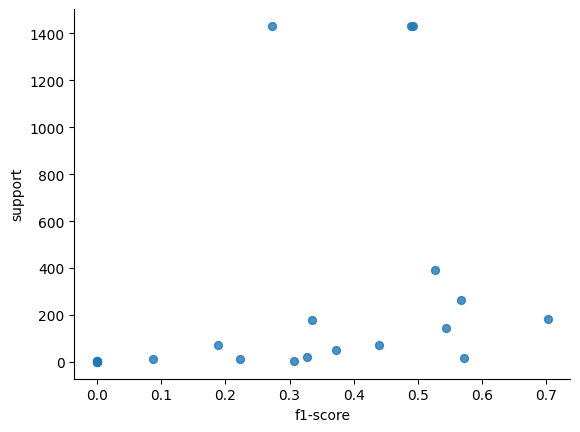

In [49]:
# f1 score is low for smaller classes

from matplotlib import pyplot as plt
dev_report.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

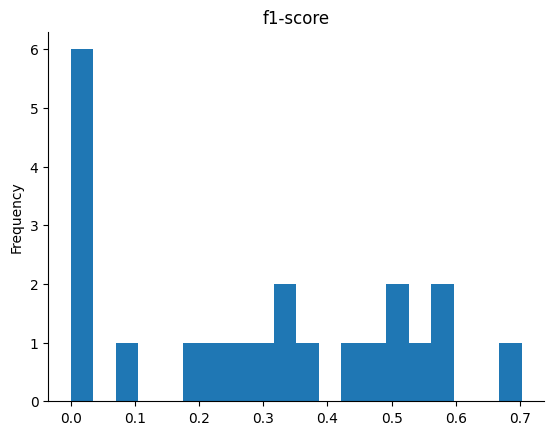

In [50]:
# most classes have low f1 score

from matplotlib import pyplot as plt
dev_report['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [51]:
dev_report_sent.sort_values('support', ascending=False)

,precision,recall,f1-score,support
micro avg,0.564706,0.476934,0.517122,1409.0
macro avg,0.341661,0.290588,0.313034,1409.0
weighted avg,0.580366,0.476934,0.523071,1409.0
positive,0.677987,0.552821,0.609040,975.0
neutral,0.407407,0.315412,0.355556,279.0
negative,0.281250,0.294118,0.287540,153.0
both,0.000000,0.000000,0.000000,2.0


In [52]:
dev_report_aspt.sort_values('support', ascending=False)

,precision,recall,f1-score,support
micro avg,0.675630,0.596439,0.633570,1348.0
macro avg,0.641364,0.620785,0.623778,1348.0
weighted avg,0.682826,0.596439,0.634082,1348.0
Food,0.702407,0.547782,0.615532,586.0
Service,0.606509,0.628834,0.617470,326.0
Whole,0.735135,0.623853,0.674938,218.0
Interior,0.721591,0.651282,0.684636,195.0
Price,0.441176,0.652174,0.526316,23.0


In [53]:
train_report = pd.DataFrame(classification_report(train_preds, train_reviews.labels.tolist(), output_dict=True)).T

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
train_report.sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support
Food_positive,1.000000,1.000000,1.000000,851.0
Service_positive,1.000000,1.000000,1.000000,612.0
Interior_positive,1.000000,0.997579,0.998788,413.0
Food_neutral,1.000000,0.997389,0.998693,383.0
Whole_positive,1.000000,0.994624,0.997305,372.0
Whole_neutral,1.000000,0.982857,0.991354,175.0
Service_neutral,0.978022,1.000000,0.988889,89.0
weighted avg,0.991425,0.984667,0.987733,3587.0
micro avg,0.989356,0.984667,0.987006,3587.0
Food_negative,0.994286,0.977528,0.985836,178.0


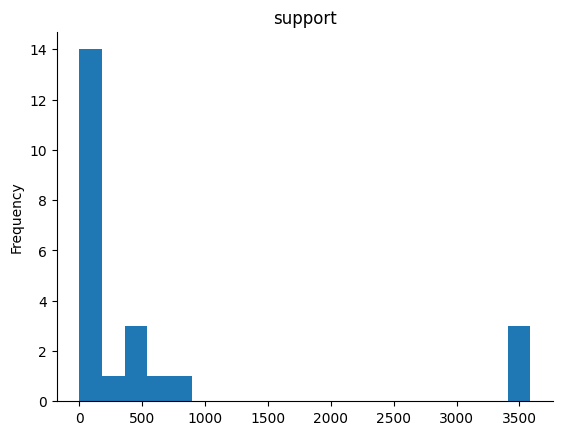

In [55]:
from matplotlib import pyplot as plt
train_report['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [56]:
# datasets are small; hence overfitting
print(len(train_reviews), len(dev_reviews))

213 71


In [57]:
! pip install -q ipymarkup

  Preparing metadata (setup.py) ... done


In [58]:
from ipymarkup import show_span_ascii_markup, show_dep_ascii_markup
import random

i = random.randint(0, len(dev_reviews))
text = dev_reviews.text[i]
spans_preds = [ele for ele in zip(*iob_to_span(tokenizer(text), dev_preds[i]))]
spans_true = [ele for ele in zip(*iob_to_span(tokenizer(text), dev_reviews.labels[i]))]

print('true\n====================================', end='\n\n')
show_span_ascii_markup(text, spans_true)

print()

print('pred\n====================================', end='\n\n')
show_span_ascii_markup(text, spans_preds)

true

Давно хотела написать, да все как-то не было времени, только сейчас 
пишу... Несколько лет посещаем ресторан 'Хутор Водограй'. Всегда все 
                               Whole_neutral────────────             
нравилось, и кухня, и обслуживание, атмосфера и настроение в 
             Food_    Service_posi  Interior_   Interior_p   
ресторане. Всегда чувствовался украинский колорит! Однако, наш 
                               Interior_positive─              
последний визит перечеркнул все позитивные впечатления. Мы с мужем 
пришли вечером, нас никто не встретил, мы долго стояли у входа и 
присели сами, в растерянности, и спустя минут 10 (!), к нам подошел 
кто-то в зауженных спущенных джинсах, дал меню и сказал: " - Ожидайте 
официанта", так как сам не смог нам помочь в выборе напитков. Очень бы
 хотелось, поинтересоваться у руководителей, считают ли они это 
                              Service_negat                     
допустимым, при условии, что ресторан высокого уровня?!! У